<a href="https://colab.research.google.com/github/RodrigodeFeo/8DTS/blob/main/trabalho_PNL_8DTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case QuantumFinance - Disciplina NLP - Classificador de chamados**

***Participantes (RM - NOME):***<br>
351070 - Danilo Fonte<br>
350640 - Felipe Fiorim<br>
351578  - Rodrigo Viera<br>
xxxx - Gabriel<br>

###**Crie um classificador de chamados aplicando técnicas de PLN**
---

A **QuantumFinance** tem um canal de atendimento via chat e precisar classificar os assuntos dos atendimentos para melhorar as tratativas dos chamados dos clientes. O canal recebe textos abertos dos clientes relatando o problema e/ou dúvida e depois é direcionado para alguma área especialista no assunto para uma melhor tratativa.​

1. Crie um modelo classificador de assuntos aplicando técnicas de PLN, que consiga classificar através de um texto o assunto conforme disponível na base de dados [1] para treinamento e validação do seu modelo.​

  O modelo precisar atingir um score na **métrica F1 Score superior a 75%**. Utilize o dataset [1] para treinar e testar o modelo, separe o dataset em duas amostras (75% para treinamento e 25% para teste com o randon_state igual a 42).​

2. Utilizar ao menos uma aplicação de modelos de GenAI (LLM´s) para criar o modelo classificador com os mesmos critérios do item 1.

Fique à vontade para testar e explorar as técnicas de pré-processamento, abordagens de NLP, algoritmos e bibliotecas, mas explique e justifique as suas decisões durante o desenvolvimento.​

**Composição da nota:​**

**50%** - Demonstrações das aplicações das técnicas de PLN (regras, pré-processamentos, tratamentos, variedade de modelos aplicados, aplicações de GenIA, organização do pipeline, etc.)​

**50%** - Baseado na performance (score) obtida com a amostra de teste no pipeline do modelo campeão (validar com  a Métrica F1 Score). **Separar o pipeline completo do modelo campeão conforme template.​**

O trabalho poderá ser feito em grupo de 2 até 4 pessoas (mesmo grupo do Startup One) e trabalhos iguais serão descontado nota e passível de reprovação.

**[1] = ​https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv**

**[F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)** com average='weighted'

In [ ]:
# CARREGANDO O DATA FRAME
import pandas as pd
df = pd.read_csv('https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv', delimiter=';')

# Façam o download do arquivo e utilizem localmente durante os testes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id_reclamacao         21072 non-null  int64 
 1   data_abertura         21072 non-null  object
 2   categoria             21072 non-null  object
 3   descricao_reclamacao  21072 non-null  object
dtypes: int64(1), object(3)
memory usage: 658.6+ KB


Bom desenvolvimento!

###**Area de desenvolvimento e validações**

Faça aqui as demonstrações das aplicações das técnicas de PLN (regras, pré-processamentos, tratamentos, variedade de modelos aplicados, organização do pipeline, etc.)​

Fique à vontade para testar e explorar as técnicas de pré-processamento, abordagens de NLP, algoritmos e bibliotecas, mas explique e justifique as suas decisões durante o desenvolvimento.​

**Import e instalação das principais libs**

In [ ]:
!pip install sentence-transformers --quiet

In [ ]:
!pip install transformers
!pip install torch

In [ ]:
!pip install accelerate -U
!pip install transformers[torch]

In [ ]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 84.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import GradientBoostingClassifier
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import precision_recall_fscore_support
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification

import torch
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import joblib
import string
import numpy as np
import gc

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


**Ajustando configuração das libs**

In [ ]:
# Download do arquivo no repositório do professor
!wget 'https://dados-ml-pln.s3-sa-east-1.amazonaws.com/skip_s300.zip'

# Descompactação do arquivo
!unzip 'skip_s300.zip' # subistitua com nome do arquivo
!ls -la

--2024-06-16 13:01:04--  https://dados-ml-pln.s3-sa-east-1.amazonaws.com/skip_s300.zip
Resolving dados-ml-pln.s3-sa-east-1.amazonaws.com (dados-ml-pln.s3-sa-east-1.amazonaws.com)... 3.5.234.137, 16.12.2.54, 52.95.165.110, ...
Connecting to dados-ml-pln.s3-sa-east-1.amazonaws.com (dados-ml-pln.s3-sa-east-1.amazonaws.com)|3.5.234.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958619745 (914M) [application/zip]
Saving to: ‘skip_s300.zip.1’

skip_s300.zip.1     100%[===================>] 914.21M  10.5MB/s    in 90s     

2024-06-16 13:02:36 (10.1 MB/s) - ‘skip_s300.zip.1’ saved [958619745/958619745]

Archive:  skip_s300.zip
replace skip_s300.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: skip_s300.txt           
total 4465752
drwxr-xr-x 1 root root       4096 Jun 16 13:03 .
drwxr-xr-x 1 root root       4096 Jun 16 12:29 ..
drwxr-xr-x 4 root root       4096 Jun 13 13:27 .config
drwxr-xr-x 2 root root       4096 Jun 16 12:59 logs
drwxr-xr-x 2 root ro

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

stops = nltk.corpus.stopwords.words('portuguese')
nlp = spacy.load('pt_core_news_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
model_skip = KeyedVectors.load_word2vec_format('skip_s300.txt')

**Análise dos principais aspectos do data set**

In [ ]:
df.describe()

,id_reclamacao,labels
count,2.107200e+04,21072.000000
mean,2.861670e+06,1.960659
std,7.709328e+05,1.410053
min,1.290253e+06,0.000000
25%,2.265054e+06,1.000000
50%,2.933378e+06,2.000000
75%,3.475881e+06,3.000000
max,4.213007e+06,4.000000


In [ ]:
df.head()

,id_reclamacao,data_abertura,categoria,descricao_reclamacao,text_norm,labels
0,3229299,2019-05-01T12:00:00-05:00,Hipotecas / Empréstimos,"Bom dia, meu nome é xxxx xxxx e agradeço se vo...",bom dia nome xxxx xxxx agradeço puder ajudar a...,0
1,3199379,2019-04-02T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...,atualizei cartão xxxx xxxx informado agente fe...,1
2,3233499,2019-05-06T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,O cartão Chase foi relatado em xx/xx/2019. No ...,cartão chase relatado entanto pedido fraudulen...,1
3,3180294,2019-03-14T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,"Em xx/xx/2018, enquanto tentava reservar um ti...",enquanto tentava reservar ticket xxxx xxxx dep...,1
4,3224980,2019-04-27T12:00:00-05:00,Serviços de conta bancária,"Meu neto me dê cheque por {$ 1600,00} Eu depos...",neto cheque depositei conta chase fundo limpo ...,2


In [ ]:
df.count()

id_reclamacao           21072
data_abertura           21072
categoria               21072
descricao_reclamacao    21072
text_norm               21072
labels                  21072
dtype: int64

In [ ]:
### verificando dimenão de linhas do data set
df.shape[0]

21072

In [ ]:
### verificando dimensão de linhas e colunas do data set
print(df.shape[0], df.shape[1])

21072 6


In [ ]:
### verificando se o data set possui valores nulos
df.isnull().sum()

id_reclamacao           0
data_abertura           0
categoria               0
descricao_reclamacao    0
text_norm               0
labels                  0
dtype: int64

**Analisando distribuição de categorias**

In [ ]:
df.categoria.value_counts()

categoria
Serviços de conta bancária             5161
Cartão de crédito / Cartão pré-pago    5006
Roubo / Relatório de disputa           4822
Hipotecas / Empréstimos                3850
Outros                                 2233
Name: count, dtype: int64

In [ ]:
def melhorar_visualizacao():
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

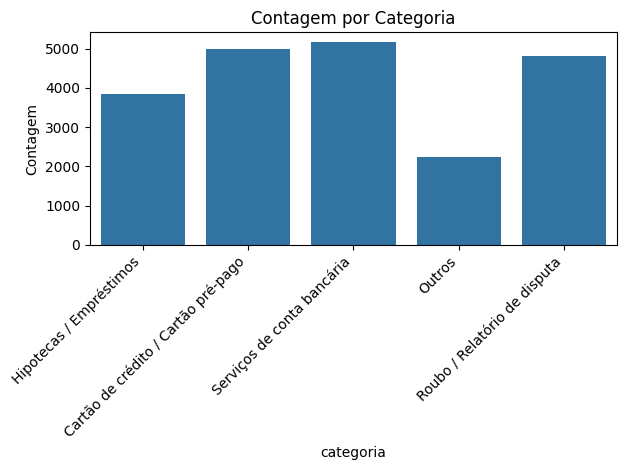

In [ ]:
### plotando gráfico com as categorias
sns.countplot(x='categoria', data=df)
plt.ylabel('Contagem')
plt.title('Contagem por Categoria')
melhorar_visualizacao()
plt.show()

In [ ]:
### criando data set apenas com categoria e descrição
df_reduzido = df[['descricao_reclamacao','categoria']]


**Treinando modelos**

**treinando utilizando TF-IDF - decisiontreeclassifier**

In [ ]:
# divisão da amostra entre treino e teste
df_train, df_test = train_test_split(
      df_reduzido,
      test_size = 0.25,
      random_state = 42
  )

In [ ]:
def lemmatizer_text(text):
  sent = []
  doc = nlp(text)
  for word in doc:
      sent.append(word.lemma_)
  return " ".join(sent)

# função que remove pontuação
def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text

# função que normaliza o texto e remove stopwords
def norm_tokenize(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stops]
    text = [y for y in text if len(y) > 2]
    #return " ".join([t for t in text])
    return text

In [ ]:
### TF-IDF com unigrama e sem stop-words em textos lematizados (Dica: crie uma função para lematizar o texto usando o Spacy).

# aplica a lematização no dataframe de treino criando um nova coluna
df_train['text_lemma'] = df_train.descricao_reclamacao.apply(lemmatizer_text)

# vetorização
vect = TfidfVectorizer(ngram_range=(1,1), use_idf=True, stop_words=stops)
vect.fit(df_train.text_lemma)
text_vect_train = vect.transform(df_train.text_lemma)

x_train = text_vect_train
y_train = df_train["categoria"]

from sklearn.tree import DecisionTreeClassifier

# treinamento do modelo
model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

# teste do modelo
# aplica a lematização no dataframe de treino criando um nova coluna
df_test['text_lemma'] = df_test.descricao_reclamacao.apply(lemmatizer_text)
x_test = vect.transform(df_test.text_lemma)
y_test = df_test["categoria"]

model.score(x_test, y_test)

0.774677296886864

In [ ]:
### salvando o modelo
joblib.dump(model, 'modelo_decision_tree.joblib')


['modelo_decision_tree.joblib']

In [ ]:
# Relatório de classificação
y_pred = model.predict(x_test)

class_report = classification_report(y_test, y_pred)
print('Relatório de Classificação:')
print(class_report)

# Calcular precisão, recall e F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Relatório de Classificação:
                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.80      0.80      0.80      1290
            Hipotecas / Empréstimos       0.81      0.81      0.81       922
                             Outros       0.74      0.76      0.75       549
       Roubo / Relatório de disputa       0.72      0.71      0.71      1204
         Serviços de conta bancária       0.79      0.79      0.79      1303

                           accuracy                           0.77      5268
                          macro avg       0.77      0.77      0.77      5268
                       weighted avg       0.77      0.77      0.77      5268

Precisão: 0.77
Recall: 0.77
F1-score: 0.77


**treinando utilizando Word2Vec - LogisticRegression**

In [ ]:
# Tokenizando e normalizando o texto
df['tokens'] = df['descricao_reclamacao'].apply(norm_tokenize)

In [ ]:
# divisão da amostra entre treino e teste
df_train, df_test = train_test_split(
      df,
      test_size = 0.25,
      random_state = 42
  )

In [ ]:
# Função para obter embeddings médios para cada texto
vectorizer = model_skip

def average_vector(words):
  vectors = [vectorizer[word] for word in words if word in vectorizer]
  if vectors:
    return sum(vectors) / len(vectors)
  else:
    vector_size = vectorizer.vector_size
    wv_res = np.zeros(vector_size)
    return wv_res

In [ ]:
# Converter textos para embeddings com Word2Vec
df_train["vetor"] = df_train["tokens"].apply(average_vector)

In [ ]:
# variáveis
x_train = df_train["vetor"]
y_train = df_train["categoria"]

# Treinar Classificador
model = LogisticRegression(random_state=42)
#model = RandomForestClassifier(random_state=42)
model.fit(list(x_train), y_train)

# Avaliação do modelo
df_test["vetor"] = df_test["tokens"].apply(average_vector)
x_test = df_test["vetor"]
y_test = df_test["categoria"]

y_pred = model.predict(list(x_test))

class_report = classification_report(y_test, y_pred)
print('Relatório de Classificação:')
print(class_report)

# Calcular precisão, recall e F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Relatório de Classificação:
                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.87      0.85      0.86      1290
            Hipotecas / Empréstimos       0.84      0.87      0.85       922
                             Outros       0.85      0.71      0.78       549
       Roubo / Relatório de disputa       0.79      0.82      0.80      1204
         Serviços de conta bancária       0.86      0.90      0.88      1303

                           accuracy                           0.84      5268
                          macro avg       0.84      0.83      0.83      5268
                       weighted avg       0.84      0.84      0.84      5268

Precisão: 0.84
Recall: 0.84
F1-score: 0.84


In [ ]:
### salvando o modelo
joblib.dump(model, 'modelo_logistic_regression_word2vec.joblib')

['modelo_logistic_regression_word2vec.joblib']

**Treinando utilizando sentence transformers**

In [ ]:
stopwords = nltk.corpus.stopwords.words('portuguese')


In [ ]:
# função que normaliza o texto e remove stopwords
def norm_tokenize(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stopwords]
    text = [y for y in text if len(y) > 2]
    return " ".join([t for t in text])

In [ ]:
df['tokens'] = df['descricao_reclamacao'].apply(norm_tokenize)

In [ ]:
st = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
vetor_embedding = st.encode(df['tokens'].to_list())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
df['vetor_st'] = list(vetor_embedding)


In [ ]:
# divisão da amostra entre treino e teste
df_train, df_test = train_test_split(
      df,
      test_size = 0.25,
      random_state = 42
  )

In [ ]:
# variáveis
x_train = df_train['vetor_st'].to_list()
y_train = df_train['categoria'].to_list()

# Treinar Classificador
model = LogisticRegression(random_state=42)
model.fit(x_train, y_train)

# Avaliação do modelo
x_test = df_test['vetor_st'].to_list()
y_test = df_test['categoria'].to_list()

y_pred = model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
class_report = classification_report(y_test, y_pred)
print('Relatório de Classificação:')
print(class_report)

# Calcular precisão, recall e F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Relatório de Classificação:
                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.79      0.80      0.79      1290
            Hipotecas / Empréstimos       0.82      0.85      0.83       922
                             Outros       0.74      0.66      0.70       549
       Roubo / Relatório de disputa       0.72      0.72      0.72      1204
         Serviços de conta bancária       0.82      0.84      0.83      1303

                           accuracy                           0.78      5268
                          macro avg       0.78      0.77      0.77      5268
                       weighted avg       0.78      0.78      0.78      5268

Precisão: 0.78
Recall: 0.78
F1-score: 0.78


In [ ]:
### salvando o modelo
joblib.dump(model, 'modelo_logistic_regression_st.joblib')

['modelo_logistic_regression_st.joblib']

In [ ]:
# variáveis
x_train = df_train['vetor_st'].to_list()
y_train = df_train['categoria'].to_list()

# Treinar Classificador
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)

# Avaliação do modelo
x_test = df_test['vetor_st'].to_list()
y_test = df_test['categoria'].to_list()

y_pred = model.predict(x_test)

In [ ]:
class_report = classification_report(y_test, y_pred)
print('Relatório de Classificação:')
print(class_report)

# Calcular precisão, recall e F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Relatório de Classificação:
                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.71      0.80      0.75      1290
            Hipotecas / Empréstimos       0.76      0.80      0.78       922
                             Outros       0.82      0.42      0.55       549
       Roubo / Relatório de disputa       0.67      0.63      0.65      1204
         Serviços de conta bancária       0.74      0.82      0.78      1303

                           accuracy                           0.72      5268
                          macro avg       0.74      0.69      0.70      5268
                       weighted avg       0.73      0.72      0.72      5268

Precisão: 0.73
Recall: 0.72
F1-score: 0.72


In [ ]:
### salvando o modelo
joblib.dump(model, 'modelo_random_forest_st.joblib')

['modelo_random_forest_st.joblib']

**Classificador utilizando o bert**

In [ ]:
### declarando funções
stopwords = nltk.corpus.stopwords.words('portuguese')

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Função para calcular métricas personalizadas
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': (preds == labels).mean(),
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# função que normaliza o texto e remove stopwords
def norm_tokenize(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stopwords]
    text = [y for y in text if len(y) > 2]
    return " ".join([t for t in text])

def lemmatizer_text(text):
  sent = []
  doc = nlp(text)
  for word in doc:
      sent.append(word.lemma_)
  return " ".join(sent)

# função que remove pontuação
def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text

In [ ]:
df['text_norm'] = df['descricao_reclamacao'].apply(norm_tokenize)

In [ ]:
# Criar um label map
label_map = {label: idx for idx, label in enumerate(df['categoria'].unique())}
df['labels'] = df['categoria'].map(label_map)

df.head()

,id_reclamacao,data_abertura,categoria,descricao_reclamacao,text_norm,labels
0,3229299,2019-05-01T12:00:00-05:00,Hipotecas / Empréstimos,"Bom dia, meu nome é xxxx xxxx e agradeço se vo...",bom dia nome xxxx xxxx agradeço puder ajudar a...,0
1,3199379,2019-04-02T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...,atualizei cartão xxxx xxxx informado agente fe...,1
2,3233499,2019-05-06T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,O cartão Chase foi relatado em xx/xx/2019. No ...,cartão chase relatado entanto pedido fraudulen...,1
3,3180294,2019-03-14T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,"Em xx/xx/2018, enquanto tentava reservar um ti...",enquanto tentava reservar ticket xxxx xxxx dep...,1
4,3224980,2019-04-27T12:00:00-05:00,Serviços de conta bancária,"Meu neto me dê cheque por {$ 1600,00} Eu depos...",neto cheque depositei conta chase fundo limpo ...,2


In [ ]:
# divisão da amostra entre treino e teste
df_train, df_test = train_test_split(
      df,
      test_size = 0.25,
      random_state = 42
  )

In [ ]:
# Carregar o tokenizer e o modelo
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=5)  # Defina o número de classes

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encodings = tokenizer(list(df_train['text_norm']), truncation=True, padding=True, max_length=512, return_tensors='pt')
eval_encodings = tokenizer(list(df_test['text_norm']), truncation=True, padding=True, max_length=512, return_tensors='pt')

In [ ]:
train_labels = torch.tensor(list(df_train['labels']))
eval_labels = torch.tensor(list(df_test['labels']))

In [ ]:
train_dataset = CustomDataset(train_encodings, train_labels)
eval_dataset = CustomDataset(eval_encodings, eval_labels)

In [ ]:
# Forçar a coleta de lixo
##gc.collect()

# Liberar cache da GPU
##torch.cuda.empty_cache()

# Mover o modelo para a GPU, se disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Definir os argumentos de treinamento
training_args = TrainingArguments(
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir='./logs',
    output_dir='./results',
    overwrite_output_dir=True
)

# Criar um trainer para facilitar o treinamento
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Dataset de treinamento
    eval_dataset=eval_dataset,     # Dataset de avaliação
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

<ipython-input-8-1323c87cdcc2>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-1323c87cdcc2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Step,Training Loss
500,0.434600
1000,0.214400


<ipython-input-8-1323c87cdcc2>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-1323c87cdcc2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
<ipython-input-8-1323c87cdcc2>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-1323c87cdcc2>:11: UserWarning: To copy construct from a tensor, it is recommended to

TrainOutput(global_step=1482, training_loss=0.25526999397638195, metrics={'train_runtime': 1802.4824, 'train_samples_per_second': 26.304, 'train_steps_per_second': 0.822, 'total_flos': 1.2474957370503168e+16, 'train_loss': 0.25526999397638195, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

<ipython-input-8-1323c87cdcc2>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-1323c87cdcc2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'eval_loss': 0.2760748565196991,
 'eval_accuracy': 0.9107820804859529,
 'eval_precision': 0.9113125260479832,
 'eval_recall': 0.9107820804859529,
 'eval_f1': 0.9108563151155257,
 'eval_runtime': 78.2938,
 'eval_samples_per_second': 67.285,
 'eval_steps_per_second': 4.215,
 'epoch': 3.0}

In [ ]:
eval_results = trainer.evaluate()


# Exibir as métricas
print("Evaluation results:")
for key, value in eval_results.items():
    print(f"  {key}: {value:.4f}")

<ipython-input-8-1323c87cdcc2>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-1323c87cdcc2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Evaluation results:
  eval_loss: 0.2761
  eval_accuracy: 0.9108
  eval_precision: 0.9113
  eval_recall: 0.9108
  eval_f1: 0.9109
  eval_runtime: 78.6689
  eval_samples_per_second: 66.9640
  eval_steps_per_second: 4.1950
  epoch: 3.0000


In [ ]:
# Salvar o modelo treinado
model_save_path = "./saved_model"
model.save_pretrained(model_save_path)

# Salvar o tokenizer
tokenizer.save_pretrained(model_save_path)

print(f"Modelo e tokenizer salvos em {model_save_path}")

Modelo e tokenizer salvos em ./saved_model


In [ ]:
!zip -r saved_model.zip saved_model


  adding: saved_model/ (stored 0%)
  adding: saved_model/tokenizer.json (deflated 72%)
  adding: saved_model/model.safetensors (deflated 7%)
  adding: saved_model/special_tokens_map.json (deflated 42%)
  adding: saved_model/tokenizer_config.json (deflated 75%)
  adding: saved_model/config.json (deflated 56%)
  adding: saved_model/vocab.txt (deflated 52%)


###**Validação do professor**

Consolidar apenas os scripts do seu **modelo campeão**, desde o carregamento do dataframe, separação das amostras, tratamentos utilizados (funções, limpezas, etc.), criação dos objetos de vetorização dos textos e modelo treinado e outras implementações utilizadas no processo de desenvolvimento do modelo.

O modelo precisar atingir um score na métrica F1 Score superior a 75%.

In [ ]:
!pip install transformers
!pip install torch
!pip install accelerate -U
!pip install transformers[torch]

In [ ]:
# CARREGANDO O DATA FRAME
import pandas as pd
df = pd.read_csv('https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv', delimiter=';')

# Façam o download do arquivo e utilizem localmente durante os testes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import GradientBoostingClassifier
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import precision_recall_fscore_support
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification

import torch
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import joblib
import string
import numpy as np
import gc

In [ ]:
### carregando stop words
stopwords = nltk.corpus.stopwords.words('portuguese')

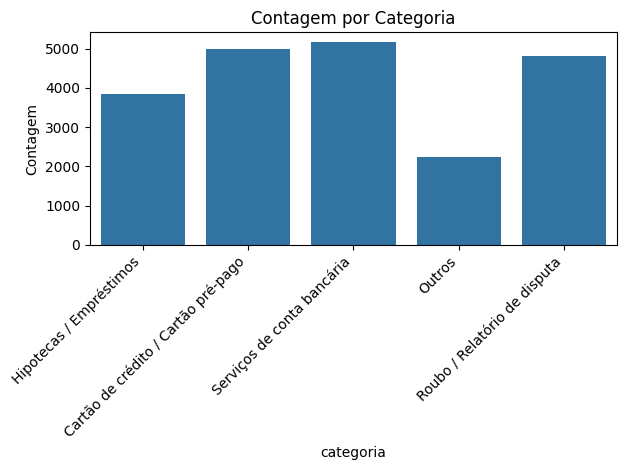

In [ ]:
### plotando gráfico com as categorias
def melhorar_visualizacao():
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

sns.countplot(x='categoria', data=df)
plt.ylabel('Contagem')
plt.title('Contagem por Categoria')
melhorar_visualizacao()
plt.show()

In [ ]:
### declarando funções


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Função para calcular métricas personalizadas
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': (preds == labels).mean(),
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# função que normaliza o texto e remove stopwords
def norm_tokenize(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stopwords]
    text = [y for y in text if len(y) > 2]
    return " ".join([t for t in text])

# função que remove pontuação
def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text

In [ ]:
###normalizando o texto
df['text_norm'] = df['descricao_reclamacao'].apply(norm_tokenize)

In [ ]:
# Criar um label map
label_map = {label: idx for idx, label in enumerate(df['categoria'].unique())}
df['labels'] = df['categoria'].map(label_map)

df.head()

,id_reclamacao,data_abertura,categoria,descricao_reclamacao,text_norm,labels
0,3229299,2019-05-01T12:00:00-05:00,Hipotecas / Empréstimos,"Bom dia, meu nome é xxxx xxxx e agradeço se vo...",bom dia nome xxxx xxxx agradeço puder ajudar a...,0
1,3199379,2019-04-02T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...,atualizei cartão xxxx xxxx informado agente fe...,1
2,3233499,2019-05-06T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,O cartão Chase foi relatado em xx/xx/2019. No ...,cartão chase relatado entanto pedido fraudulen...,1
3,3180294,2019-03-14T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,"Em xx/xx/2018, enquanto tentava reservar um ti...",enquanto tentava reservar ticket xxxx xxxx dep...,1
4,3224980,2019-04-27T12:00:00-05:00,Serviços de conta bancária,"Meu neto me dê cheque por {$ 1600,00} Eu depos...",neto cheque depositei conta chase fundo limpo ...,2


In [ ]:
# divisão da amostra entre treino e teste
df_train, df_test = train_test_split(
      df,
      test_size = 0.25,
      random_state = 42
  )

In [ ]:
# Carregar o tokenizer e o modelo
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=5)  # Defina o número de classes

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
### gerando encodings de treino e teste
train_encodings = tokenizer(list(df_train['text_norm']), truncation=True, padding=True, max_length=512, return_tensors='pt')
eval_encodings = tokenizer(list(df_test['text_norm']), truncation=True, padding=True, max_length=512, return_tensors='pt')

In [ ]:
### criando tensores de labels de treino e teste
train_labels = torch.tensor(list(df_train['labels']))
eval_labels = torch.tensor(list(df_test['labels']))

In [ ]:
### gerando dataset de treino e teste
train_dataset = CustomDataset(train_encodings, train_labels)
eval_dataset = CustomDataset(eval_encodings, eval_labels)

In [ ]:
# Mover o modelo para a GPU, se disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Definir os argumentos de treinamento
training_args = TrainingArguments(
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir='./logs',
    output_dir='./results',
    overwrite_output_dir=True
)

# Criar um trainer para facilitar o treinamento
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Dataset de treinamento
    eval_dataset=eval_dataset,     # Dataset de avaliação
    compute_metrics=compute_metrics
)

In [ ]:
### treinar modelo
trainer.train()

In [ ]:
### avaliar resultado
eval_results = trainer.evaluate()


# Exibir as métricas
print("Evaluation results:")
for key, value in eval_results.items():
    print(f"  {key}: {value:.4f}")

In [ ]:
# Salvar o modelo treinado
model_save_path = "./saved_model"
model.save_pretrained(model_save_path)

# Salvar o tokenizer
tokenizer.save_pretrained(model_save_path)

print(f"Modelo e tokenizer salvos em {model_save_path}")